(ch_mapalgebra)=
# Map Algebra

Map algebra, also known as cartographic modeling, is a simple yet powerful algebra that utilizes a variety of tools, operators, and functions to perform geographic analysis using raster data {cite:p}`tomlin90`. We may distinguish between the following operations:

+ **Local** operations work on single cell locations.

+ **Focal** operations work on cell locations within a neighborhood.

+ **Zonal** operations work on cell locations within zones.

+ **Global** operations work on all cells within the raster.

<img src="figs/map_algebra.png" alt="focal" width="600"/>

## Python libraries

Several Python libraries provide functions for these kind of operations:

* [gdal](https://gdal.org/en/stable/api/index.html#python-api): reprojection, resampling, rasterization, sieve filter.
* [scikit-image](https://scikit-image.org): a large portfolio of image processing algorithms that take numpy arrays.
* [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html#module-scipy.ndimage) : Basic filtering, mathematical morphology, regions properties. Takes numpy arrays.
* [OpenCV](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html): computer vision.

Relevant submodules in the scikit-image [API](https://scikit-image.org/docs/stable/api/api.html):

* [skimage.morphology](https://scikit-image.org/docs/stable/api/skimage.morphology.html): morphological operators
* [skimage.measure](https://scikit-image.org/docs/stable/api/skimage.measure.html): derive metrics, labels
* [skimage.filters](https://scikit-image.org/docs/stable/api/skimage.filters.html): focal operators, convolution filters
* [skimage.segmentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html): segmentation algorithms




## Imports

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from osgeo import gdal
from skimage import morphology, filters, measure
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn_image as isns # graphics library
from geopy_map_algebra_fun import plot_boa, readRasterAsArray

gdal.UseExceptions()

# image orientation - default in matplotlib but 
# somehow changed by seaborn_image : (
rcParams['image.origin'] = 'upper'

I also import the functions `plot_boa` and `readRasterAsArray` from the file `geopy_map_algebra_fun.py`. The file must be stored in the same directory as your script. The name used in the import statement is simply the module's filename without the .py extension. We use the imported routines to load and visualize a spatial subset of a Landsat 8 image acquired over Berlin.

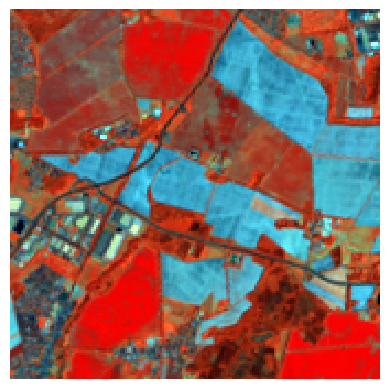

In [2]:
fname = '../data/week03_arrays/landsat8_berlin/20180520_LEVEL2_LND08_BOA.tif'
l8img = readRasterAsArray(fname, subset=[4546000, 3260000, 4551000, 3255000])
plot_boa(l8img)

## Visualize raster data

Visualization of numpy arrays can be accomplished with the `pyplot` submodule in `matplotlib`. See chapter 4 in {cite:p}`vanderplas16` for a comprehensive overview of matplotlib's capabilities.


```python
from matplotlib import pyplot as plt

plt.imshow(my2darray)
plt.show()
```

## Rasterize

The gdal library provides you with direct access to some powerful tools for projecting and resampling images, rasterization, and sieve filtering {cite:p}`gdal`. Check out the section on the [GDAL Python Utilities](https://gdal.org/en/stable/api/python/utilities.html) in the documentation of the [Python API](https://gdal.org/en/stable/api/index.html#python-api).

* osgeo.gdal.BuildVRT
* osgeo.gdal.Warp
* osgeo.gdal.Translate
* osgeo.gdal.SieveFilter
* osgeo.gdal.Rasterize

The `Rasterize()`  function in gdal takes two main arguments: the filename (or dataset) of the output raster and the filename (or dataset) of the input vector to be rasterized. Furthermore, there are several options that you can set to define the output raster. Search for `osgeo.gdal.RasterizeOptions` in the gdal API to find a list and definition of those options. Usually, it is convenient if the pixel grid of the rasterized dataset matches some existing raster data set, to facilitate overlay operations. Below is some example code that reads the resolution and bounding box coordinates from a reference raster. The rasterized vector dataset then matches the pixel grid of the reference raster.

```python
ref_src = gdal.Open(reference_file)
gt = ref_src.GetGeoTransform()
lx = gt[0]
uy = gt[3]
rx = gt[0] + ref_src.RasterXSize * gt[1]
ly = gt[3] + ref_src.RasterYSize * gt[5]

out_ds = gdal.Rasterize(output_tif, input_vec, format='GTiff', outputType=gdal.GDT_Int32,
                        creationOptions=["COMPRESS=DEFLATE"], noData=0,
                        xRes=gt[1], outputBounds=[lx, ly, rx, uy],
                        yRes=gt[5], attribute='id')
out_ds = None
```

## Local operations

The value for each cell on the output layer is a function of one or more cell values at the same location on the input layer(s), e.g. raster math, masking operations.

<img src="figs/local.png" alt="local" width="600"/>

We covered local operations in session 3 (raster data). For example, we can calculate the Normalized Difference Vegetation Index (NDVI).

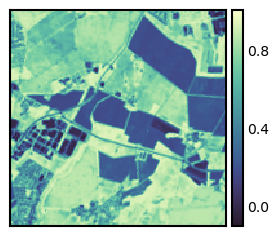

In [3]:
red = l8img[2, :]; nir = l8img[3, :]
ndvi = (nir - red) / (nir + red)
fig, ax = plt.subplots(figsize=(3, 3)); isns.imgplot(ndvi, ax);

## Focal operations

* Compute an output value for each cell as a function of the cells that are within its neighborhood
* Refered to as: convolution, filtering, kernel or moving window

<img src="figs/focal.png" alt="focal" width="600"/>

### Kernel

Focal operations perform neighborhood operations using a moving window, also called kernel. A kernal can be defined using a numpy array. The scikit-image submodule morphology provides helper functions to create 2-D kernels: `disk()`, `square()`, `diamond()`, and 3-D kernels: `cube()` and `ball()`. Change the kernel size and shape below and observe the outputs.

In [4]:
from skimage import morphology
morphology.disk(radius=2)

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

### Convolution filters

A focal operation applies a kernal to an image. This is also called a convolution. During a convolution, the convolution kernel is multiplied with the corresponding image pixels. The sum of the convolution is then applied to the pixel that is centered around the kernel.

$$\begin{bmatrix}
Image
\end{bmatrix} * \begin{bmatrix}
Kernel
\end{bmatrix} = 
\begin{bmatrix}
Output
\end{bmatrix}
$$

$$\begin{bmatrix}
1 & 1 & 1\\
4 & 4 & 2\\
4 & 4 & 2
\end{bmatrix} * \begin{bmatrix}
0 & 1 & 0\\
1 & 1 & 1\\
0 & 1 & 0
\end{bmatrix} = 
\begin{bmatrix}
  &   &  \\
  & 15 &  \\
  &   &  
\end{bmatrix}
$$

#### Smoothing

Different effects such as blurring (averaging), sharpening, edge-detection are accomplished by defining different kernels. For example, a mean convolution filter has the following kernel:

$$\begin{bmatrix}
Image
\end{bmatrix} * \begin{bmatrix}
Kernel
\end{bmatrix} = 
\begin{bmatrix}
Output
\end{bmatrix}
$$

$$\begin{bmatrix}
1 & 1 & 1\\
4 & 4 & 2\\
4 & 4 & 2
\end{bmatrix} * \begin{bmatrix}
0 & \frac{1}{5} & 0\\
\frac{1}{5} & \frac{1}{5} & \frac{1}{5}\\
0 & \frac{1}{5} & 0
\end{bmatrix} = 
\begin{bmatrix}
  &   &  \\
  & 3 &  \\
  &   &  
\end{bmatrix}
$$

#### Edge detection

The Sobel operator emphasizes edges. Here is the Sobel operator for vertical and horizontal edge detection.

Vertical edge detection:

$$\begin{bmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{bmatrix}$$

Horizontal edge detection:

$$\begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}$$

The `ndimage` module from the `scipy` library provides a convolution function. Here, we apply an averaging kernel to the NDVI image.

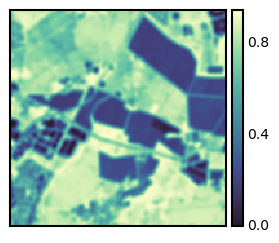

In [5]:
mean_kernel = morphology.disk(2)/np.sum(morphology.disk(2))
arr = ndimage.convolve(ndvi, mean_kernel)
fig, ax = plt.subplots(figsize=(3, 3)); isns.imgplot(arr, ax);

Let's try the horizontal sobel kernel.

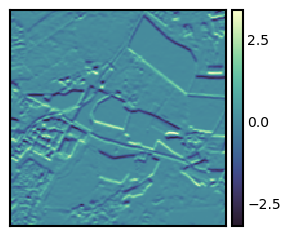

In [6]:
sobelh_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
arr = ndimage.convolve(ndvi, sobelh_kernel)
fig, ax = plt.subplots(figsize=(3, 3)); isns.imgplot(arr, ax);

### Filters

Filters may consist of one or multiple convolutions. Several filters apply a series of different convolution kernels to achieve a desired outcome. The [**scipy.ndimage**](https://docs.scipy.org/doc/scipy/reference/ndimage.html#) module and the [**scikit-image.filters**](https://scikit-image.org/docs/stable/api/skimage.filters.html) module provide a number of filters, like a sobel filter:

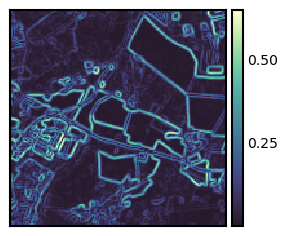

In [7]:
arr = filters.sobel(ndvi)
fig, ax = plt.subplots(figsize=(3, 3)); isns.imgplot(arr, ax);

.. or a median filter.

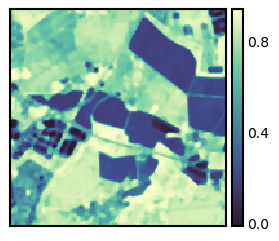

In [8]:
arr = filters.median(ndvi, footprint=morphology.disk(2))
fig, ax = plt.subplots(figsize=(3, 3)); isns.imgplot(arr, ax);

### Morphological operators

Morphological operations..
* are simple transformations applied to binary or grayscale images.
* combine an image with a structuring element.
* are applied to increase (*dilate*) and decrease (*erosion*) the size of objects in images. 
* are applied to close gaps (*closing*) between objects and open them (*opening*).

The structuring element is a type of kernel or mask. However, instead of applying a convolution, we are only performing simple tests on the pixels. The scikit-image websites has some interesting [examples](
https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html). The four main basic morphological operators are:

+ **Erosion:** A foreground pixel in the input image is kept only if **all** pixels inside the structuring element are > 0. Otherwise, the pixels are set to 0 (i.e., background). Erosion is useful for removing small blobs in an image or disconnecting two connected objects.

+ **Dilation:** The opposite of an erosion is a dilation. Dilations increase the size of foreground objects and are especially useful for joining broken parts of an image together. A center pixel of the structuring element is set to foreground if **any** pixel in the structuring element is > 0.

+ **Opening:** ..is an erosion followed by a dilation. Performing an opening operation allows us to remove small blobs from an image: first an erosion is applied to remove the small blobs, then a dilation is applied to regrow the size of the original object.

+ **Closing:** ..is a dilation followed by an erosion. A closing is used to close holes inside of objects or for connecting components together.

In [9]:
bin_img = ndvi < 0.4 # creates a binary mask based on a threshold
arr1 = morphology.binary_erosion(bin_img, morphology.disk(1))
arr2 = morphology.binary_dilation(bin_img, morphology.disk(1))
arr3 = morphology.binary_opening(bin_img, morphology.disk(1))
arr4 = morphology.binary_closing(bin_img, morphology.disk(1))


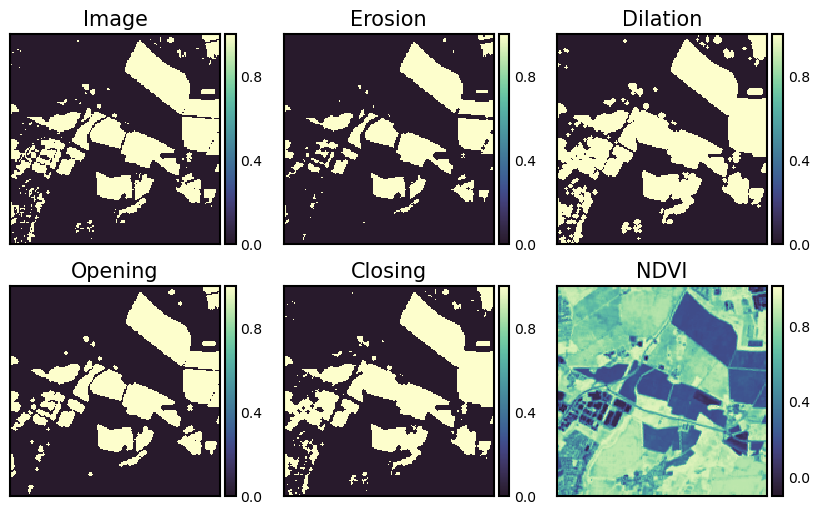

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
isns.imgplot(bin_img, ax[0,0]);
ax[0,0].set_title("Image");
isns.imgplot(arr1, ax[0,1]);
ax[0,1].set_title("Erosion");
isns.imgplot(arr2, ax[0,2]);
ax[0,2].set_title("Dilation");
isns.imgplot(arr3, ax[1,0]);
ax[1,0].set_title("Opening")
isns.imgplot(arr4, ax[1,1]);
ax[1,1].set_title("Closing"); 
isns.imgplot(ndvi, ax[1,2]);
ax[1,2].set_title("NDVI");
plt.close();
fig

## Map segmentation

Sometimes it is useful to identify pixel regions of the same values. The [`label()`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label) function from the `scikit-image.measures` modul identifies and labels contiguous patches. You can choose between 4 (connectivity=1) and 8 (connectivity=2) connected neighbors. The GIS term for this type of analysis is **clump** or **clumping**.

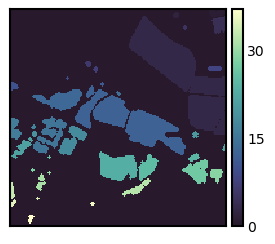

In [11]:
patch_img = measure.label(arr3, background=0, connectivity=2)
fig, ax = plt.subplots(figsize=(3, 3)); isns.imgplot(patch_img, ax);

The module `scikit-image.measure` also provides helper functions to extract information from each patch. The function [`regionprops()`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops) returns a list of region-property objects for a region image. A region-property object contains information on area (in pixel), bounding box, centroid, length of major and minor axis, and several more. See more [examples](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html) on the scikit-image website.

In [12]:
for region in measure.regionprops(patch_img):
    if region.area > 100:
        print(region.label)

3
4
12
13
15
16
18
23
25
27


The function [`regionprops_table()`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table) returns a dictionary of the region properties. The dictionary can be converted into a pandas DataFrame.

In [13]:
dt = measure.regionprops_table(patch_img, properties=('label', 'area', 'centroid'))
pd.DataFrame(dt).head(5)

label    area  centroid-0  centroid-1
0      1    77.0    2.753247  160.207792
1      2    19.0    5.157895  128.157895
2      3  2654.0   52.522607  134.041070
3      4   122.0   12.286885  162.245902
4      5     8.0   14.500000  135.000000

### Minimum Mapping Unit

A **sieve** filter removes speckle and contiguous patches/regions from a categorical raster by replacing the values with values from the neighoring pixels. The sieve filter preserves the basic shapes of the patches, and therefore it is an excellent choice when an increase in the **minimum mapping unit** (MMU) of a map is desired. The minimum mapping unit is the specific size of the smallest feature that is being reliably mapped in your map. A **sieve** filter is available in gdal via command line tools and gdal's python bindings. The function `SieveFilter` operates on a gdal band object (not on a numpy array). Below, we create an in-memory gdal raster to hold the binary image used in previous demonstrations, and also the filtered output. The *minimum mapping unit* is 11 pixel (~ 1 ha).

In [14]:
neighbors = 8
mmu = 11 # minimum mapping unit in pixels

drv = gdal.GetDriverByName('MEM') # in-memory driver
src_ds = drv.Create('', bin_img.shape[1], bin_img.shape[0], 1, gdal.GDT_Byte)
src_band = src_ds.GetRasterBand(1)
src_band.WriteArray(bin_img, 0, 0) # write binary image to source band

# create in-memory dataset for the sieved output
dst_ds = drv.Create('', bin_img.shape[1], bin_img.shape[0], 1, gdal.GDT_Byte)
dst_band = dst_ds.GetRasterBand(1)

gdal.SieveFilter(src_band, None, dst_band, mmu, neighbors)

arr5 = dst_band.ReadAsArray() # read sieved image from memory

dst_ds = None; src_ds = None # destroy references

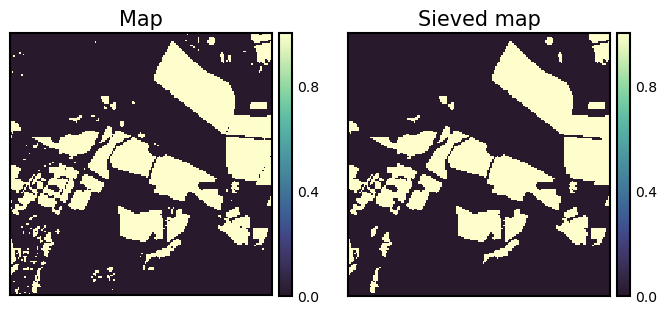

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
isns.imgplot(bin_img, ax[0]);
ax[0].set_title("Map");
isns.imgplot(arr5, ax[1]);
ax[1].set_title("Sieved map");
plt.show();

## Zonal operations

Zonal operations compute a new value for each cell as a function of the cell values within a zone containing the cell. The *zonal raster* defines the zones. The *value raster* contains input cell values.

<img src="figs/zonal.png" alt="focal" width="600"/>

Zonal statistical operations:

* Calculate statistics for each cell by using all the cell values within a zone
* Zonal statistical operations: mean, median, sum, minimum, maximum, range, majority, variance, etc.
* Output is a table, where each row contains the statistics for a zone. The table can be joined back to the zone layer.
* `numpy.histogram2d` and `scipy.stats.binned_statistic_2d` (Garrard, Ch. 11)
* Can you think of your own code solution based on NumPy?



## Block operations

Block statistical operations calculate a statistic (e.g., mean, maximum, or sum) for input cells within a fixed set of **non-overlapping** windows or neighborhoods.

<img src="figs/block_statistics.png" alt="blockstats" class="bg-primary mb-1" width="600px">

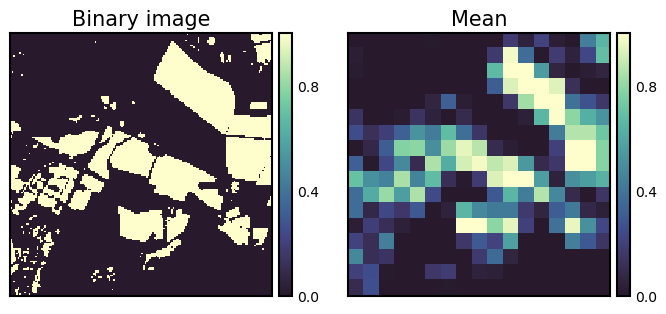

In [16]:
frac = measure.block_reduce(bin_img, block_size=10, func=np.mean)
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))
isns.imgplot(bin_img, ax[0]); ax[0].set_title("Binary image");
isns.imgplot(frac, ax[1]); ax[1].set_title("Mean"); plt.show();

## Global operations

* Operations that compute an output raster where the value of each output cell is a function of all the cells in the input raster
* Global statistical operations
* Distance operations:
    - Euclidean distance, .e.g, proximity raster
    - Cost distance